# HVAC Power Consumption Prediction in Electric Vehicles

## Main GOAL: To develop a highly accurate, real-time predictive model for the HVAC system's instantaneous power consumption in electric vehicles, utilizing a comprehensive,real-world dataset

### Notebook focusses on POWER Consumption Without Thermal Disturbance 

In [1]:
# 1) setup and reproducibility
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
tf.random.set_seed(42)


2025-09-17 06:59:09.261322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758092349.357808     585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758092349.391202     585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2) imports
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib


In [3]:
# 3) load cleaned datasets
tripA = pd.read_csv('/kaggle/input/hvac-cleaneddata/TripA_clean.csv')
tripB = pd.read_csv('/kaggle/input/hvac-cleaneddata/TripB_clean.csv')

print("TripA.shape:", tripA.shape)
print("TripB.shape:", tripB.shape)


TripA.shape: (467701, 35)
TripB.shape: (627092, 53)


In [4]:
# 4) feature lists (exact cleaned names from your data)
features_A = [
    "velocity", "longitudinal_acceleration", "motor_torque", "elevation", "throttle",
    "battery_voltage", "battery_current", "soc", "battery_temperature", "max_battery_temperature", "battery_power",
    "ambient_temperature", "cabin_temperature_sensor", "cabin_ambient_delta", "heat_exchanger_temperature",
    "requested_coolant_temperature", "heater_voltage", "heater_current",
    "heating_power_lin", "heating_power_can", "aircon_power",
    "requested_heating_power_prev", "aircon_power_prev", "heating_power_can_prev"
]

# TripB has the same + extra temperature sensors
extra_B = [
    "temperature_coolant_heater_inlet", "temperature_coolant_heater_outlet",
    "temperature_heat_exchanger_outlet",
    "temperature_defrost_lateral_left", "temperature_defrost_lateral_right",
    "temperature_defrost_central", "temperature_defrost_central_left", "temperature_defrost_central_right",
    "temperature_footweel_driver", "temperature_footweel_co_driver",
    "temperature_feetvent_co_driver", "temperature_feetvent_driver",
    "temperature_head_co_driver", "temperature_head_driver",
    "temperature_vent_central_right", "temperature_vent_central_left", "temperature_vent_right"
]
features_B = features_A + extra_B

target_col = "hvac_target_power"

# keep only columns that actually exist (safety)
features_A = [c for c in features_A if c in tripA.columns]
features_B = [c for c in features_B if c in tripB.columns]
print("Using features_A:", len(features_A))
print("Using features_B:", len(features_B))


Using features_A: 24
Using features_B: 41


In [5]:
# 5) chronological split for TripA
split_A = int(len(tripA) * 0.8)
X_A = tripA[features_A]
y_A = tripA[target_col]
X_A_train, X_A_test = X_A.iloc[:split_A], X_A.iloc[split_A:]
y_A_train, y_A_test = y_A.iloc[:split_A], y_A.iloc[split_A:]
print("TripA train/test:", X_A_train.shape, X_A_test.shape)

# TripB
split_B = int(len(tripB) * 0.8)
X_B = tripB[features_B]
y_B = tripB[target_col]
X_B_train, X_B_test = X_B.iloc[:split_B], X_B.iloc[split_B:]
y_B_train, y_B_test = y_B.iloc[:split_B], y_B.iloc[split_B:]
print("TripB train/test:", X_B_train.shape, X_B_test.shape)


TripA train/test: (374160, 24) (93541, 24)
TripB train/test: (501673, 41) (125419, 41)


In [6]:
# 6) Random Forest
rf_params = {"n_estimators":200, "max_depth":20, "random_state":42, "n_jobs":-1}

rf_A = RandomForestRegressor(**rf_params)
rf_A.fit(X_A_train, y_A_train)
yA_rf_pred = rf_A.predict(X_A_test)

rf_B = RandomForestRegressor(**rf_params)
rf_B.fit(X_B_train, y_B_train)
yB_rf_pred = rf_B.predict(X_B_test)


In [7]:
# 7) XGBoost
xgb_params = {"n_estimators":300, "learning_rate":0.05, "max_depth":6, "subsample":0.8, "colsample_bytree":0.8, "random_state":42, "n_jobs":-1}

xgb_A = xgb.XGBRegressor(**xgb_params)
xgb_A.fit(X_A_train, y_A_train)
yA_xgb_pred = xgb_A.predict(X_A_test)

xgb_B = xgb.XGBRegressor(**xgb_params)
xgb_B.fit(X_B_train, y_B_train)
yB_xgb_pred = xgb_B.predict(X_B_test)


In [8]:
# 8) LSTM prep: scale then build sequences (chronological split inside)
from sklearn.preprocessing import StandardScaler

def prepare_lstm_sequences(df, features, target, seq_len=30, train_frac=0.8):
    X = df[features].values
    y = df[target].values.reshape(-1,1)
    # scalers for invert later
    scaler_X = StandardScaler().fit(X)
    scaler_y = StandardScaler().fit(y)
    Xs = scaler_X.transform(X)
    ys = scaler_y.transform(y).flatten()
    # build sequences
    X_seq, y_seq = [], []
    for i in range(len(Xs) - seq_len):
        X_seq.append(Xs[i:i+seq_len])
        y_seq.append(ys[i+seq_len])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    split_idx = int(len(X_seq) * train_frac)
    X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
    y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]
    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_X, scaler_y

seq_len = 30   # use past 30 samples; reduce to e.g. 10 for speed if needed

X_A_train_seq, X_A_test_seq, y_A_train_seq, y_A_test_seq, scalerA_X, scalerA_y = prepare_lstm_sequences(tripA, features_A, target_col, seq_len=seq_len)
X_B_train_seq, X_B_test_seq, y_B_train_seq, y_B_test_seq, scalerB_X, scalerB_y = prepare_lstm_sequences(tripB, features_B, target_col, seq_len=seq_len)

print("LSTM sequences TripA:", X_A_train_seq.shape, X_A_test_seq.shape)
print("LSTM sequences TripB:", X_B_train_seq.shape, X_B_test_seq.shape)


LSTM sequences TripA: (374136, 30, 24) (93535, 30, 24)
LSTM sequences TripB: (501649, 30, 41) (125413, 30, 41)


In [9]:
# 9) LSTM model definition
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# TripA LSTM
model_A_lstm = build_lstm_model((X_A_train_seq.shape[1], X_A_train_seq.shape[2]))
history_A = model_A_lstm.fit(
    X_A_train_seq, y_A_train_seq,
    validation_data=(X_A_test_seq, y_A_test_seq),
    epochs=100,     # large max, early stopping will cut earlier
    batch_size=256, # adjust to memory
    callbacks=[early_stop],
    verbose=1
)

# TripB LSTM
model_B_lstm = build_lstm_model((X_B_train_seq.shape[1], X_B_train_seq.shape[2]))
history_B = model_B_lstm.fit(
    X_B_train_seq, y_B_train_seq,
    validation_data=(X_B_test_seq, y_B_test_seq),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


2025-09-17 07:17:37.955126: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 95s 62ms/step - loss: 0.0472 - mae: 0.1211 - val_loss: 0.0059 - val_mae: 0.0445
Epoch 2/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 90s 61ms/step - loss: 0.0070 - mae: 0.0464 - val_loss: 0.0075 - val_mae: 0.0493
Epoch 3/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 89s 61ms/step - loss: 0.0049 - mae: 0.0369 - val_loss: 0.0100 - val_mae: 0.0548
Epoch 4/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 90s 62ms/step - loss: 0.0038 - mae: 0.0311 - val_loss: 0.0162 - val_mae: 0.0783
Epoch 5/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 89s 61ms/step - loss: 0.0033 - mae: 0.0270 - val_loss: 0.0171 - val_mae: 0.0912
Epoch 6/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 86s 58ms/step - loss: 0.0029 - mae: 0.0239 - val_loss: 0.0204 - val_mae: 0.0996
Epoch 7/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 88s 60ms/step - loss: 0.0026 - mae: 0.0220 - val_loss: 0.0149 - val_mae: 0.0941
Epoch 1/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 128s 63ms/step - loss: 0.0993 - mae: 0.1032 - val_loss: 0.0019 - val_mae: 0.0329
Epoch 2/100
196

In [10]:
# 10) predict and inverse-transform LSTM outputs
yA_lstm_scaled_pred = model_A_lstm.predict(X_A_test_seq).reshape(-1,1)
yA_lstm_pred = scalerA_y.inverse_transform(yA_lstm_scaled_pred).flatten()
yA_lstm_true = scalerA_y.inverse_transform(y_A_test_seq.reshape(-1,1)).flatten()

yB_lstm_scaled_pred = model_B_lstm.predict(X_B_test_seq).reshape(-1,1)
yB_lstm_pred = scalerB_y.inverse_transform(yB_lstm_scaled_pred).flatten()
yB_lstm_true = scalerB_y.inverse_transform(y_B_test_seq.reshape(-1,1)).flatten()


2923/2923 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step


In [11]:
# 11) evaluation helper
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

# TripA: RF / XGB evaluate on chronological test portion (X_A_test, y_A_test)
metrics_A_rf = evaluate(y_A_test.values, yA_rf_pred)
metrics_A_xgb = evaluate(y_A_test.values, yA_xgb_pred)

# TripA LSTM: note yA_lstm_true corresponds to LSTM test region (shifted by seq_len)
metrics_A_lstm = evaluate(yA_lstm_true, yA_lstm_pred)

# TripB
metrics_B_rf = evaluate(y_B_test.values, yB_rf_pred)
metrics_B_xgb = evaluate(y_B_test.values, yB_xgb_pred)
metrics_B_lstm = evaluate(yB_lstm_true, yB_lstm_pred)

# show table
results = pd.DataFrame({
    "TripA_RF": metrics_A_rf,
    "TripA_XGB": metrics_A_xgb,
    "TripA_LSTM": metrics_A_lstm,
    "TripB_RF": metrics_B_rf,
    "TripB_XGB": metrics_B_xgb,
    "TripB_LSTM": metrics_B_lstm
}).T

print(results)


                 MAE      RMSE        R2
TripA_RF    0.000007  0.000053  1.000000
TripA_XGB   0.015204  0.034510  0.996092
TripA_LSTM  0.021405  0.037043  0.995497
TripB_RF    0.000143  0.000690  0.999999
TripB_XGB   0.012172  0.036995  0.998370
TripB_LSTM  0.054558  0.071562  0.993903


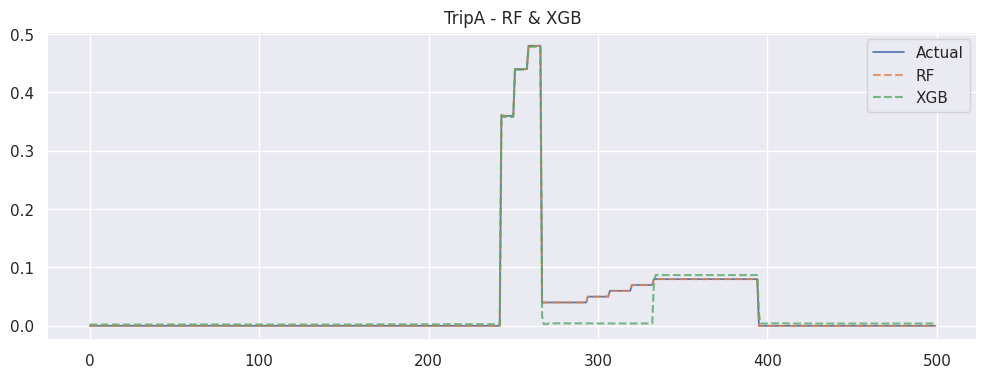

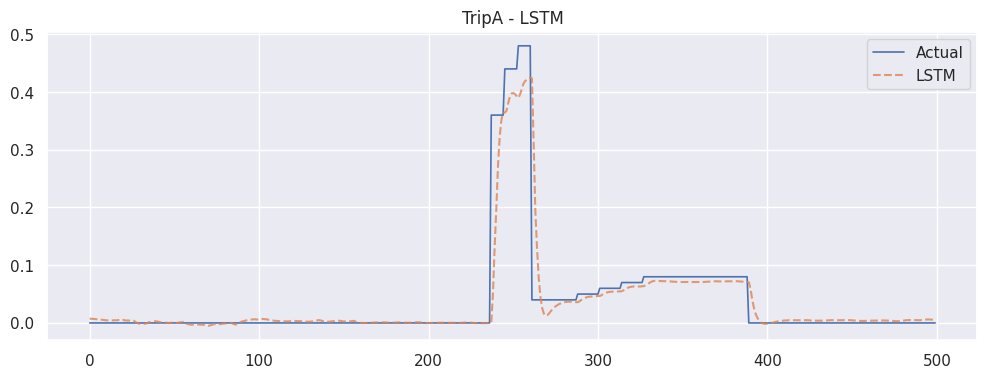

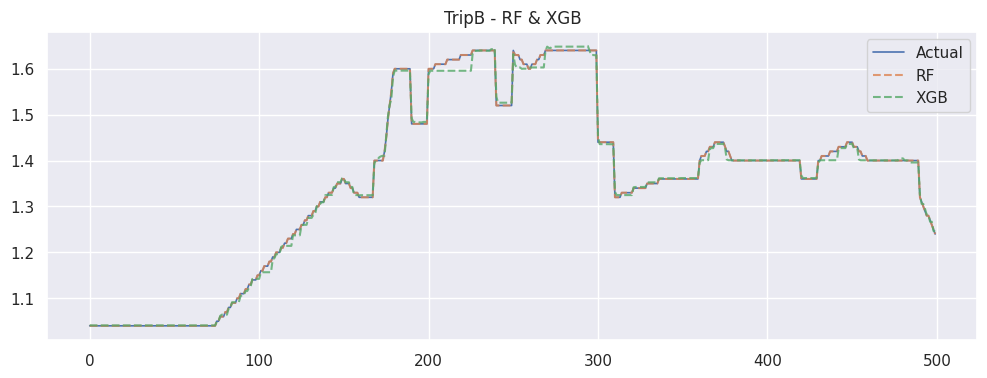

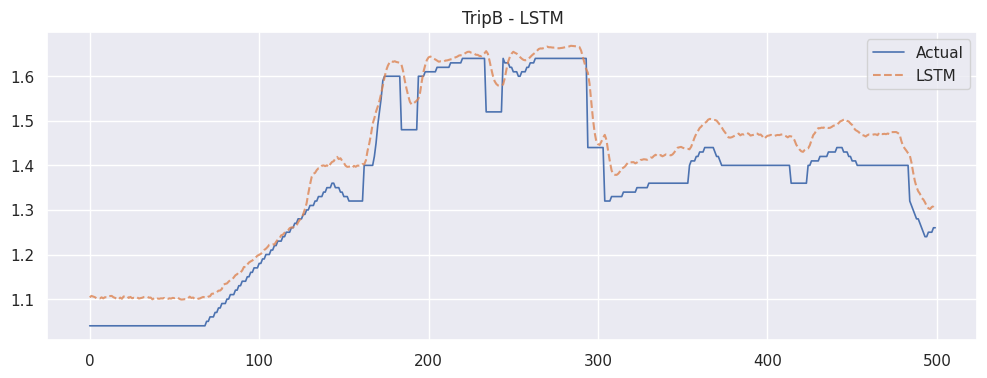

In [12]:
# 12) plot a short slice for each model and trip
def quick_plot(true, preds, labels, n=500, title=''):
    plt.figure(figsize=(12,4))
    plt.plot(true[:n], label='Actual', linewidth=1.2)
    for p, lab in zip(preds, labels):
        plt.plot(p[:n], label=lab, alpha=0.8, linestyle='--')
    plt.legend()
    plt.title(title)
    plt.show()

# TripA (RF vs XGB on same timeline)
quick_plot(y_A_test.values, [yA_rf_pred, yA_xgb_pred], ['RF','XGB'], n=500, title='TripA - RF & XGB')

# TripA LSTM: note different y length (seq offset) — plot separately
quick_plot(yA_lstm_true, [yA_lstm_pred], ['LSTM'], n=500, title='TripA - LSTM')

# TripB
quick_plot(y_B_test.values, [yB_rf_pred, yB_xgb_pred], ['RF','XGB'], n=500, title='TripB - RF & XGB')
quick_plot(yB_lstm_true, [yB_lstm_pred], ['LSTM'], n=500, title='TripB - LSTM')

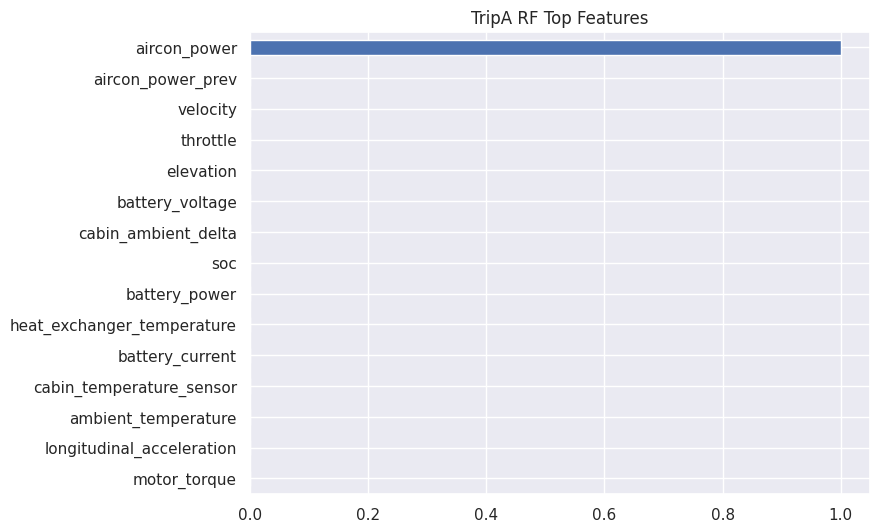

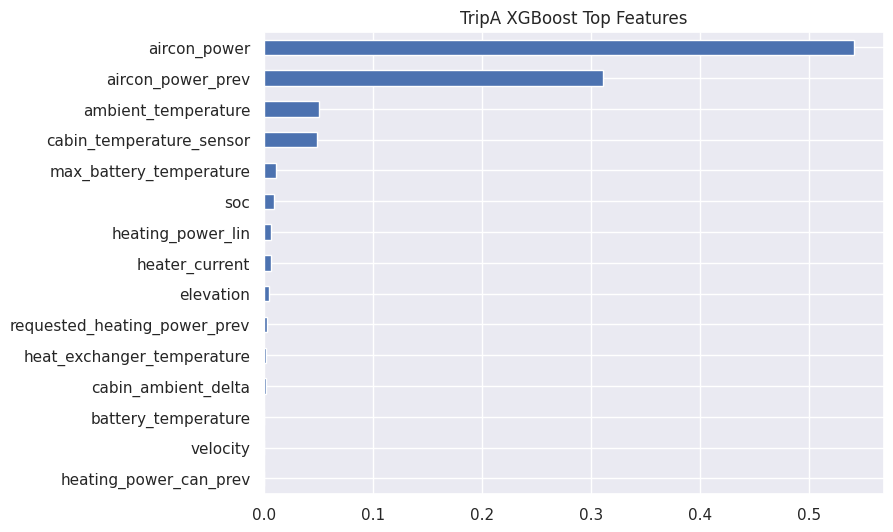

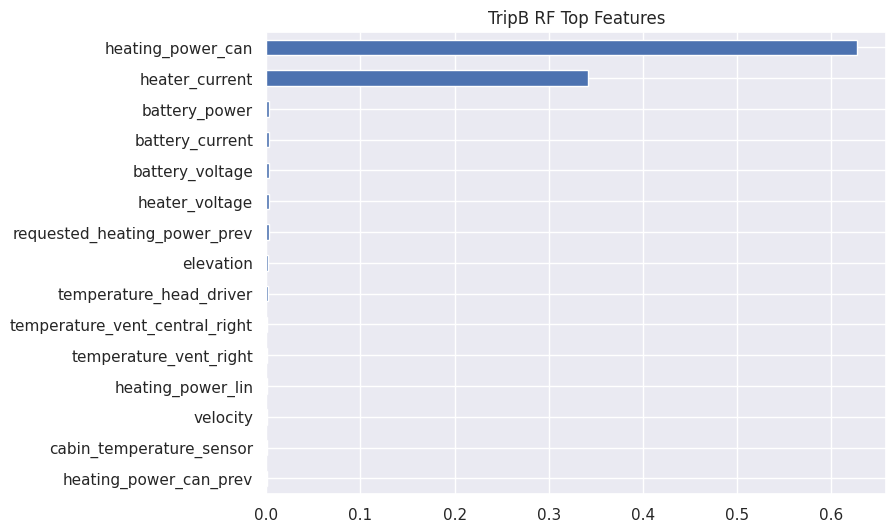

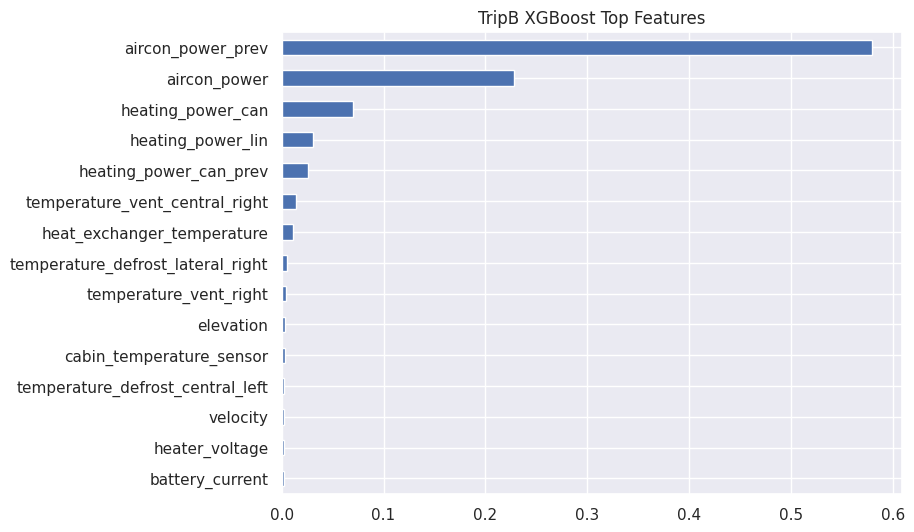

In [13]:
# 13) Top features for TripA RF & XGB
importances_rfA = pd.Series(rf_A.feature_importances_, index=features_A).sort_values(ascending=False)
importances_xgbA = pd.Series(xgb_A.feature_importances_, index=features_A).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances_rfA.head(15).plot.barh(title='TripA RF Top Features'); plt.gca().invert_yaxis(); plt.show()

plt.figure(figsize=(8,6))
importances_xgbA.head(15).plot.barh(title='TripA XGBoost Top Features'); plt.gca().invert_yaxis(); plt.show()

# TripB
importances_rfB = pd.Series(rf_B.feature_importances_, index=features_B).sort_values(ascending=False)
importances_xgbB = pd.Series(xgb_B.feature_importances_, index=features_B).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances_rfB.head(15).plot.barh(title='TripB RF Top Features'); plt.gca().invert_yaxis(); plt.show()

plt.figure(figsize=(8,6))
importances_xgbB.head(15).plot.barh(title='TripB XGBoost Top Features'); plt.gca().invert_yaxis(); plt.show()

In [14]:
# 14) save models and metrics
joblib.dump(rf_A, "/kaggle/working/rf_A.joblib")
joblib.dump(xgb_A, "/kaggle/working/xgb_A.joblib")
model_A_lstm.save("/kaggle/working/lstm_A.h5")

joblib.dump(rf_B, "/kaggle/working/rf_B.joblib")
joblib.dump(xgb_B, "/kaggle/working/xgb_B.joblib")
model_B_lstm.save("/kaggle/working/lstm_B.h5")

results.to_csv("/kaggle/working/hvac_model_comparison_metrics.csv", index=True)